# Bayesian Linear Regression

In [3]:
# Activate local environment, see `Project.toml`
import Pkg; Pkg.activate("."); Pkg.instantiate(); 

  Activating project at `~/git/biaslab/RxInfer.jl/examples`


In this example, we are going to perform a simple linear regression problem, but in the Bayesian setting. We specify the model's likelihood as:

$$\begin{aligned}
y_i = a * x_i + b
\end{aligned}$$

where $x_i$ and $y_i$ are observed values and $a$ and $b$ are random variables with the following priors:

$$\begin{aligned}
    p(a) &= \mathcal{N}(a|m_a, v_a) \\
    p(b) &= \mathcal{N}(b|m_b, v_b)
\end{aligned}$$

In [4]:
using RxInfer, Random, Plots, StableRNGs, BenchmarkTools

In [5]:
@model function linear_regression(n)
    a ~ NormalMeanVariance(0.0, 1.0)
    b ~ NormalMeanVariance(0.0, 100.0)
    
    x = datavar(Float64, n)
    y = datavar(Float64, n)
    
    for i in 1:n
        y[i] ~ NormalMeanVariance(a * x[i] + b, 1.0)
    end
end

Next step is to define an inference procedure.

In order to test our inference procedure we create a test dataset where observations are corrupted with noise (with known variance).

In [6]:
reala = 0.5
realb = 25

N = 250

rng = StableRNG(1234)

xorig = collect(1:N)

xdata = xorig .+ randn(rng, N)
ydata = realb .+ reala .* xorig .+ randn(rng, N);

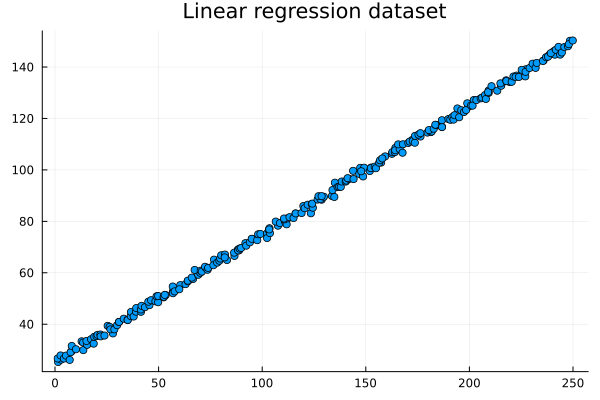

In [8]:
scatter(xdata, ydata, title = "Linear regression dataset", legend=false)

In [10]:
results = inference(
    model = linear_regression(length(xdata)), 
    data  = (y = ydata, x = xdata), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()), 
    iterations = 20
);

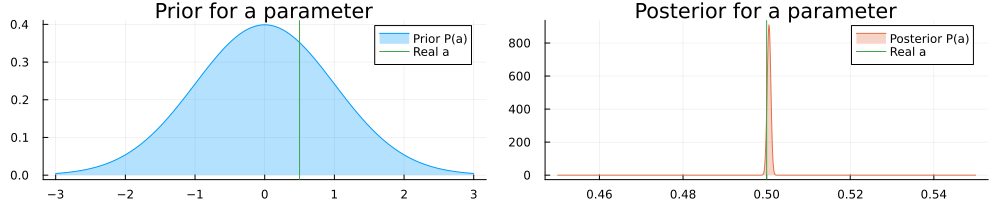

In [11]:
pra = plot(range(-3, 3, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 1.0), x), title="Prior for a parameter", fillalpha=0.3, fillrange = 0, label="Prior P(a)", c=1,)
pra = vline!(pra, [ reala ], label="Real a", c = 3)
psa = plot(range(0.45, 0.55, length = 1000), (x) -> pdf(results.posteriors[:a], x), title="Posterior for a parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(a)", c=2,)
psa = vline!(psa, [ reala ], label="Real a", c = 3)

plot(pra, psa, size = (1000, 200))

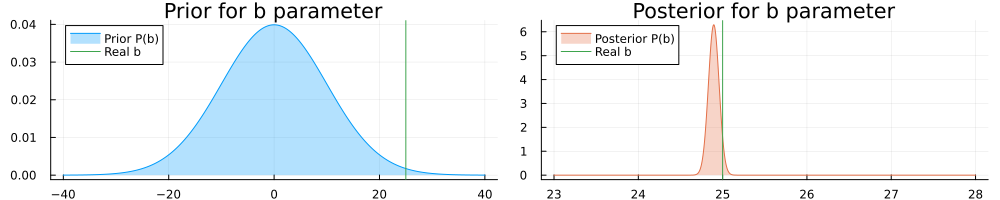

In [12]:
prb = plot(range(-40, 40, length = 1000), (x) -> pdf(NormalMeanVariance(0.0, 100.0), x), title="Prior for b parameter", fillalpha=0.3, fillrange = 0, label="Prior P(b)", c=1, legend = :topleft)
prb = vline!(prb, [ realb ], label="Real b", c = 3)
psb = plot(range(23, 28, length = 1000), (x) -> pdf(results.posteriors[:b], x), title="Posterior for b parameter", fillalpha=0.3, fillrange = 0, label="Posterior P(b)", c=2, legend = :topleft)
psb = vline!(psb, [ realb ], label="Real b", c = 3)

plot(prb, psb, size = (1000, 200))

In [13]:
a = results.posteriors[:a]
b = results.posteriors[:b]

println("Real a: ", reala, " | Estimated a: ", mean(a), " | Error: ", abs(mean(a) - reala))
println("Real b: ", realb, " | Estimated b: ", mean(b), " | Error: ", abs(mean(b) - realb))

Real a: 0.5

 | Estimated a: 0.5005720088325591 | Error: 0.0005720088325591455
Real b: 25 | Estimated b: 24.894860313391554 | Error: 0.10513968660844597


We can see that ReactiveMP.jl estimated real values of linear regression coefficients with high precision. Let's also test the benchmark of the resulting inference procedure.

In [14]:
@benchmark inference(
    model = linear_regression(length($xdata)), 
    data  = (y = $ydata, x = $xdata), 
    initmessages = (b = NormalMeanVariance(0.0, 100.0), ), 
    returnvars   = (a = KeepLast(), b = KeepLast()), 
    iterations = 20
)

BenchmarkTools.Trial: 54 samples with 1 evaluation.
 Range (min … max):  82.076 ms … 126.629 ms  ┊ GC (min … max): 0.00% … 23.04%
 Time  (median):     88.609 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   93.796 ms ±  11.686 ms  ┊ GC (mean ± σ):  6.73% ±  9.27%

   █ ▃▁  ▃ ▁ ▁                       ▁                          
  ▄█▇██▇▄█▇█▁█▄▇▇▄▄▁▁▁▄▁▁▁▁▁▁▁▁▁▁▁▁▁▄█▇▇▄▁▁▄▇▁▁▁▁▁▁▁▁▁▁▁▁▄▁▁▁▄ ▁
  82.1 ms         Histogram: frequency by time          123 ms <

 Memory estimate: 36.08 MiB, allocs estimate: 833801.